In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Path and robot construction

A path consists of a list of **TrajectoryPt** objects.
The position and orientation of a trajectory point can be a fixed floating point number.
If the tasks allows deviation from the path, a **TolerancedNumber** can be used instead of a fixed on.

In [2]:
from ppr.path import TolerancedNumber, TrajectoryPt

# create tolerances for x-position and orientation
# TolerancedNumber(nominal, lower_limit, upper_limit, samples)
dx    = TolerancedNumber(1, 0.9, 1.1, samples=3)
angle = TolerancedNumber(0.0, -0.5, 0.5, samples=5)

# create a list with path points
path1 = []
n_path = 6
for i in range(n_path):
    yi = 0.3 + i * 0.6 / n_path # vertical line from y = 0.3 to y = 0.9
    path1.append(TrajectoryPt([dx, yi, angle]))

A robot base class is defined in the ppr.robot module. However the (analytical) inverse kinematics must be added manually. In addition, the discretisation of redundant kinematics is also added manually at the moment.

For this example we use a robot with 2 prismatic joints, followed by three revolute joints. This robot is already added to the ppr.robot module.

In [3]:
from ppr.robot import Robot_2P3R

robot1 = Robot_2P3R([2, 1, 0.5, 0.5, 0.3])

The inverse kinematics are solved for the three prismatic joints. Then the 2 prismatic joints are sampled in there joint limit range. The result is a whole bunch of inverse kinematic solutions for an end effector pose.

In [4]:
sol = robot1.ik([0.5, 1.5, np.pi / 4])
print("Found {} inverse kinematic solutions.".format(len(sol['q'])))

Found 28 inverse kinematic solutions.


In [5]:
# change the default sampling and joint limits
robot1.ik_samples = [10, 5] # first and second prismatic joint
robot1.set_joint_limtis = [(0, 1), (0, 2), (), (), ()] # only set joint limits on first two joints

sol = robot1.ik([0.5, 1.5, np.pi / 4])
print("Found {} inverse kinematic solutions.".format(len(sol['q'])))

Found 56 inverse kinematic solutions.


Collision objects are given as a list of shapes. In this case only Rectangles are implemented.

In [6]:
from ppr.geometry import Rectangle

sc1 = [Rectangle(0.0, 0.4, 0.1, 0.2, -0.3),
       Rectangle(0.2, 0.8, 0.1, 0.5, 0.2)]

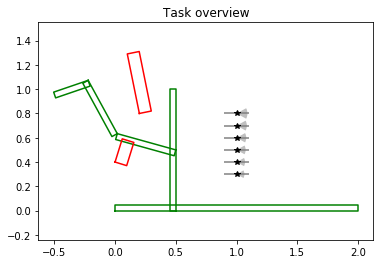

In [7]:
fig1, ax1 = plt.subplots()
plt.title("Task overview")
ax1.axis('equal')
robot1.plot(ax1, [0.5, 0.5, 1.3, -0.8, 1.4], 'g') # plot robot for arbitrary joint values
for tp in path1: tp.plot(ax1)
for r in sc1: r.plot(ax1, 'r')
plt.show()

# Sampling based path following

We now calculate all possible inverse kinematic solutions that are not in collision.

This function can be quit slow. I have c++ code for collision checking between rectangles to improve performance by a factor 5 or so. But this is not yet added to master branch.

In [8]:
from ppr.sampling import cart_to_joint

path_js = cart_to_joint(robot1, path1, check_collision=True, scene=sc1)

# show the number of sampled joint positions for every trajectory point
[qp.shape[0] for qp in path_js]

[768, 808, 852, 903, 931, 922]

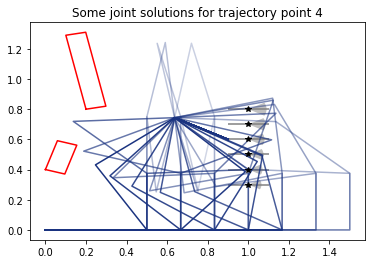

In [9]:
fig2, ax2 = plt.subplots()
robot1.plot_path_kinematics(ax2, path_js[3][1:30])
plt.title("Some joint solutions for trajectory point 4")
for tp in path1: tp.plot(ax2)
for r in sc1: r.plot(ax2, 'r')
plt.show()

Now we can look in all this joint solutions for a sequence that gives us the shortest path.
Shortest is defined as minimal joint motion, but could be any cost between two joint solutions.

Using breadth-first search starting from all joint solutions of the first trajectory point, the shortest path is found. Dijkstra's algorithm (aka ordering the queue in breath-first search) does gives a big advantage for this graph structure.

In [10]:
from ppr.sampling import get_shortest_path

sol = get_shortest_path(path_js)

print(sol['success'])

converting type of Q
[227 232 240 259 261 492]
True


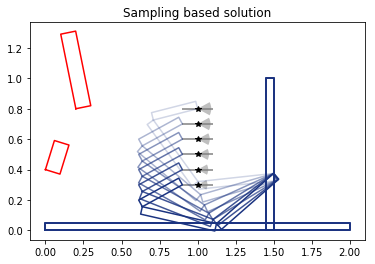

In [11]:
fig3, ax3 = plt.subplots()
plt.title("Sampling based solution")
ax3.axis('equal')
robot1.plot_path(ax3, sol['path'])
for tp in path1: tp.plot(ax3)
for r in sc1: r.plot(ax3, 'r')
plt.show()

# Optimisation based path following

This code is even less mature, but the basics are working. The main issue at the moment is missing joint limits and good testing of the dynamics.

We have to set the robot inertial parameters for the dynamic calculations. (For example when minimising joint torque.)

**The sampling based solution is used as initial guess.** This is in essence the goal of all this code, to combine different solution approaches.

In [12]:
# set mass, cg-positoin and mass moment of inertia for each link
robot1.set_link_inertia([1, 1, 1, 0.5, 0.5],
                        [0.5, 0.5, 0.25, 0.25, 0.15],
                        [0.05, 0.05, 0.05, 0.05, 0.05])

# use the sampling based solution as initial guess
q_init = sol['path']

In [13]:
from ppr.optim import get_optimal_trajectory

q_opt, dq_opt, ddq_opt = get_optimal_trajectory(robot1, path1, q_init)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5000097516628629
            Iterations: 93
            Function evaluations: 3177
            Gradient evaluations: 93


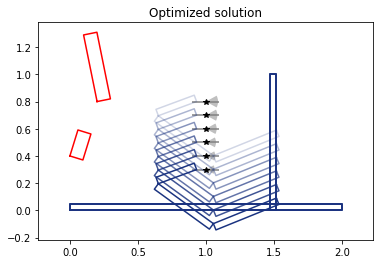

In [14]:
fig4, ax4 = plt.subplots()
plt.title("Optimized solution")
ax4.axis('equal')
robot1.plot_path(ax4, q_opt)
for tp in path1: tp.plot(ax4)
for r in sc1: r.plot(ax4, 'r')
plt.show()

## Use collision constraints

In [15]:
q_opt2, dq_opt2, ddq_opt2 = get_optimal_trajectory(robot1, path1, q_init,
                                               check_collision=True, scene=sc1)

Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.6526670318502261
            Iterations: 101
            Function evaluations: 3389
            Gradient evaluations: 98


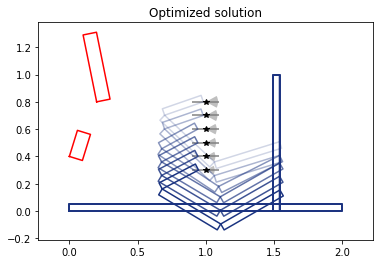

In [16]:
fig5, ax5 = plt.subplots()
plt.title("Optimized solution")
ax5.axis('equal')
robot1.plot_path(ax5, q_opt2)
for tp in path1: tp.plot(ax5)
for r in sc1: r.plot(ax5, 'r')
plt.show()

# Change objective function

Experimental alternative objectives

In [17]:
weights = w={'joint_motion': 0.0, 'path_error': 1.0, 'torque': 0.0}

q_opt2, _, _ = get_optimal_trajectory(robot1, path1, q_init,
                                                 check_collision=True, scene=sc1,
                                                 w=weights)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.806195620872295e-07
            Iterations: 27
            Function evaluations: 865
            Gradient evaluations: 27


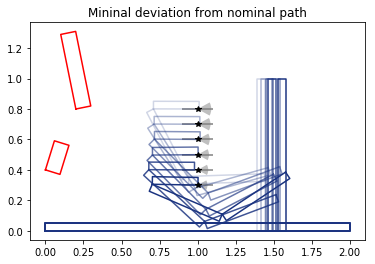

In [18]:
fig6, ax6 = plt.subplots()
plt.title("Mininal deviation from nominal path")
ax6.axis('equal')
robot1.plot_path(ax6, q_opt2)
for tp in path1: tp.plot(ax6)
for r in sc1: r.plot(ax6, 'r')
plt.show()

In [19]:
weights = w={'joint_motion': 0.0, 'path_error': 0.0, 'torque': 1.0}

q_opt3, _, _ = get_optimal_trajectory(robot1, path1, q_init,
                                                 check_collision=True, scene=sc1,
                                                 w=weights)

Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.22810386089107593
            Iterations: 101
            Function evaluations: 3359
            Gradient evaluations: 97


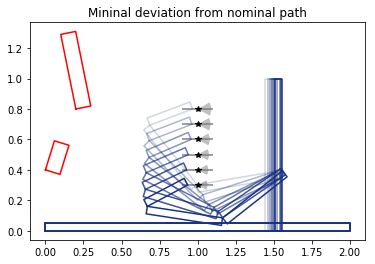

In [20]:
fig7, ax7 = plt.subplots()
plt.title("Mininal deviation from nominal path")
ax7.axis('equal')
robot1.plot_path(ax7, q_opt3)
for tp in path1: tp.plot(ax7)
for r in sc1: r.plot(ax7, 'r')
plt.show()